In [38]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
%matplotlib inline

In [20]:
# Import the data and remove unnecessary columns

df = pd.read_csv('/Users/jack.galvin/Desktop/Predictive/sfdcreport.csv')
df.drop(['Account Name', 'Website', 'Opportunity Name', 'Type', 'Close Date', 'Created Date'], axis = 1, inplace = True)

In [21]:
# Encode 'Closed Won' and 'Sales Order Signed' as 1, 'Closed Lost' as 0

df['Stage'].replace(to_replace = ['Closed Lost', 'Closed Won', 'Sales Order Signed'], value = [0, 1, 1], inplace = True)

In [22]:
# Check for null values to decide on how to impute NaN

df.isna().sum()

Stage                     0
PET Annual Revenue    27469
PET Employees         12872
PET Match Score        8945
$ARR                      0
Age                       0
dtype: int64

In [23]:
df.describe()

,Stage,PET Annual Revenue,PET Employees,PET Match Score,$ARR,Age
count,49150.000000,2.168100e+04,3.627800e+04,40205.000000,4.915000e+04,49150.000000
mean,0.090173,5.981529e+09,9.378244e+03,80.485064,2.946262e+03,89.482930
std,0.286432,2.936147e+10,5.702437e+04,7.901704,2.261256e+04,110.070348
min,0.000000,0.000000e+00,0.000000e+00,19.000000,-3.150000e+04,0.000000
25%,0.000000,4.270000e+06,2.900000e+01,75.000000,0.000000e+00,23.000000
50%,0.000000,4.133000e+07,1.100000e+02,82.000000,0.000000e+00,57.000000
75%,0.000000,8.671300e+08,7.817500e+02,83.000000,0.000000e+00,119.000000
max,1.000000,1.086850e+12,2.200000e+06,100.000000,1.500000e+06,6530.000000


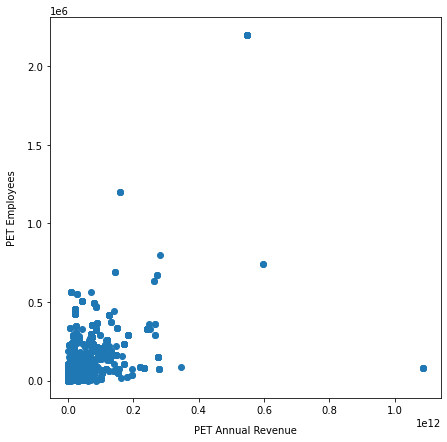

In [24]:
# Scatter plot to visually identify large outliers

plt.figure(figsize = (7,7))
plt.xlabel('PET Annual Revenue', labelpad = 10)
plt.ylabel('PET Employees', labelpad = 10)
plt.scatter(df['PET Annual Revenue'], df['PET Employees']);

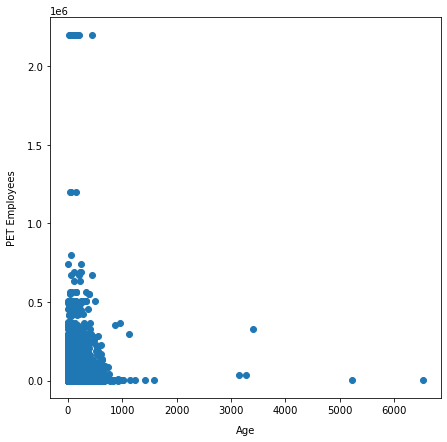

In [25]:
# Scatter plot to visually identify large outliers

plt.figure(figsize = (7,7))
plt.xlabel('Age', labelpad = 10)
plt.ylabel('PET Employees', labelpad = 10)
plt.scatter(df['Age'], df['PET Employees']);

In [26]:
# Remove outliers

df = df[(df['PET Annual Revenue'] < 400000000000) & (df['PET Employees'] < 1000000) & (df['Age'] < 2000)]

In [27]:
# Scale data with RobustScaler since there are a few large outliers

scaler = QuantileTransformer()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled.head()

,Stage,PET Annual Revenue,PET Employees,PET Match Score,$ARR,Age
0,0.0,0.823863,0.906054,0.034535,0.0,0.693694
1,0.0,0.925936,0.949950,NaN,0.0,0.406406
2,0.0,0.146146,0.041542,0.013514,0.0,0.353353
3,0.0,0.974258,0.926093,0.319319,0.0,0.559059
4,0.0,0.762402,0.753590,0.789289,0.0,0.505005


In [28]:
# Impute using KNNImputer

imputer = KNNImputer(n_neighbors = 15)
df_scaled = pd.DataFrame(imputer.fit_transform(df_scaled),columns = df_scaled.columns)

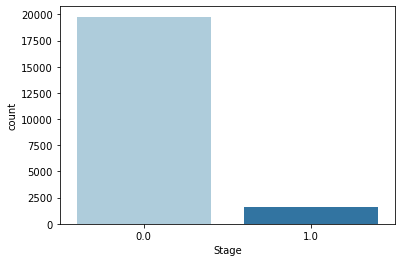

In [29]:
# Data Exploration - Wins and Losses

sns.countplot(x = df_scaled['Stage'], palette = 'Paired');

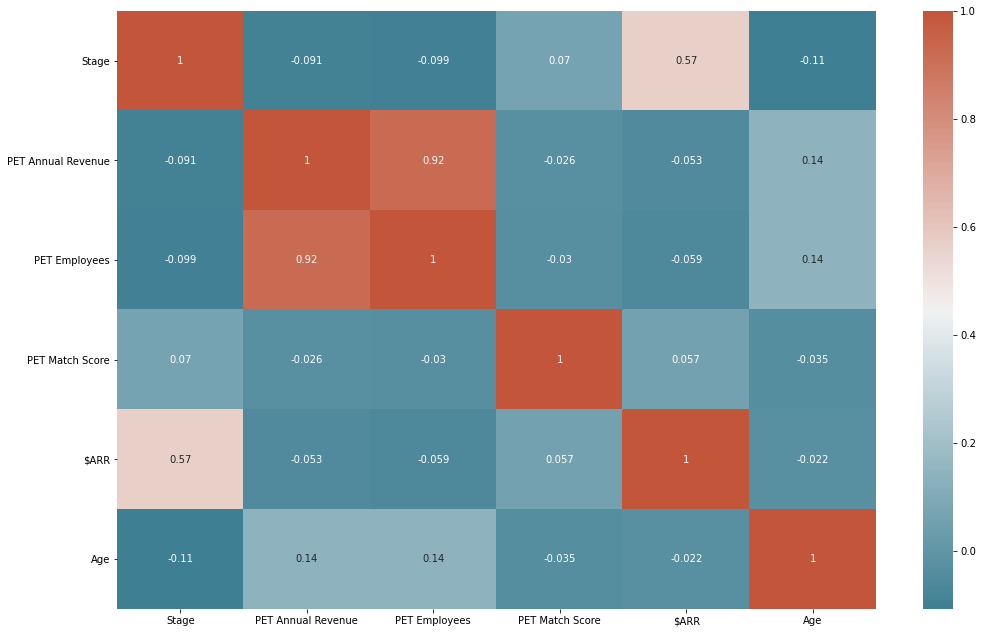

In [30]:
# Identify correlations

correlation = df_scaled.corr('spearman')
fig, ax = plt.subplots(figsize = (17,11))
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot=True, cmap = sns.diverging_palette(220,20, as_cmap=True), ax=ax);

In [31]:
# Split train and test data

X = df_scaled[['PET Match Score', 'PET Annual Revenue', 'PET Employees', 'Age']]
y = df_scaled['Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42, shuffle = True)

In [32]:
# Implement and fit the model

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

In [33]:
# Evaluate model's performance

rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring = "roc_auc")

In [34]:
# Print out a performance report

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5865   21]
 [ 512   11]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5886
         1.0       0.34      0.02      0.04       523

    accuracy                           0.92      6409
   macro avg       0.63      0.51      0.50      6409
weighted avg       0.87      0.92      0.88      6409



=== All AUC Scores ===
[0.62007247 0.60641263 0.57734926 0.6289661  0.62229621 0.60929881
 0.63295299 0.58292163 0.63772862 0.64182271]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6159821417074441


In [35]:
# Tune hyperparemeters using RandomizedSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.0min finished


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [36]:
# Implement and fit using updated hyperparemeters

rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 10, max_features = "sqrt", min_samples_split = 10, min_samples_leaf = 2)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv = 10, scoring = "roc_auc")

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5882    4]
 [ 518    5]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5886
         1.0       0.56      0.01      0.02       523

    accuracy                           0.92      6409
   macro avg       0.74      0.50      0.49      6409
weighted avg       0.89      0.92      0.88      6409



=== All AUC Scores ===
[0.67073896 0.65293225 0.64544483 0.64498087 0.65784388 0.66991015
 0.68837433 0.63514002 0.72250131 0.70071419]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6688580791376223


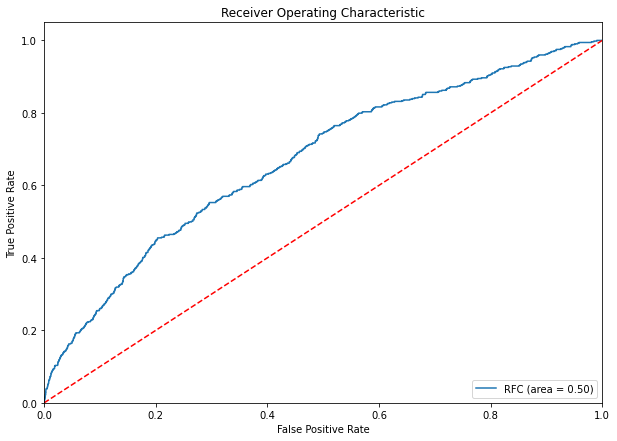

In [44]:
# Evaluate performance by plotting ROC Curve

rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='RFC (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('RFC_ROC')
plt.show()